In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras as ks
import seaborn as sns
from PIL import Image
%matplotlib inline

# Survey Answers and Image Ranking

Download the survey results.

In [111]:
surv = pd.read_csv('../Data/Survey/CleanedResults.csv')
surv = surv.iloc[: , 1:] #Just to remove this Unnamed 0 column
surv.describe()

,Age,Percentage of lifetime in a city,Image1 ID,Image2 ID,Winner,Person ID
count,14254.000000,14254.000000,14254.000000,14254.000000,14254.000000,1.425400e+04
mean,32.559632,0.536940,227.012418,230.548688,230.618353,2.395758e+07
std,20.909320,0.412010,132.377288,131.419003,131.196153,2.509833e+07
min,12.000000,0.000000,0.000000,0.000000,0.000000,2.160600e+04
25%,20.000000,0.000000,112.000000,117.000000,111.000000,2.299160e+06
50%,22.000000,0.754967,228.000000,233.000000,235.000000,2.013920e+07
75%,30.000000,0.929360,341.000000,344.000000,338.750000,2.443626e+07
max,96.000000,1.000000,457.000000,457.000000,457.000000,9.617434e+07


### Build Ranking for images
Build a win ratio, which is calculated by taking the ratio between number of wins over number of total appearences in battles.

In [112]:
win = pd.DataFrame(surv['Winner'].value_counts())
win.sort_index(ascending=True, inplace=True)

In [113]:
im1 = pd.DataFrame(surv['Image1 ID'].value_counts())
im1.sort_index(ascending=True, inplace=True)

In [114]:
im2 = pd.DataFrame(surv['Image2 ID'].value_counts())
im2.sort_index(ascending=True, inplace=True)

In [115]:
occur = pd.DataFrame(im1.values+im2.values, columns=['Image occurence'])

In [116]:
contest = pd.concat([occur, win],axis=1)

In [117]:
contest['Win ratio'] = contest['Winner'] / contest['Image occurence']

In [118]:
pd.set_option('display.max_rows', None)

In [119]:
contest.reset_index(inplace=True)
contest.fillna(0.0, inplace=True)

In [120]:
contest.drop(['Image occurence','Winner'], axis=1, inplace=True)

# Feature engineering

Build the dataframe,plot the distribution, and perform a PCA.

### Building the dataframe

In [121]:
obj_rgb_bright = pd.read_csv('images_features.csv')
df_model = pd.merge(contest, obj_rgb_bright, left_on='index', right_on='Image number', how='outer')
obj_num = df_model['Image number'].value_counts()
obj_num.sort_index(ascending=True, inplace=True)
obj_num = np.array(obj_num)
obj_num = pd.DataFrame(obj_num, columns=['Number of obj.'])
size = df_model[['Image number','Size of box']].groupby('Image number').sum()
size = size / 360000
df_model.drop(['Object','Reliability','Size of box'], axis=1, inplace=True)
df_model = pd.merge(df_model, size, on='Image number', how='outer')
df_model = df_model.groupby('Image number').mean()


In [122]:
df_model_final = pd.read_csv('Segmented_features.csv')
# df_model_final.describe()

In [123]:
df_model_final['Size of box'] = df_model['Size of box']
df_model_final['Win ratio'] = contest['Win ratio']
df_model_final = df_model_final.iloc[: , 1:] #Just to remove this Unnamed 0 column

In [124]:
df_model_final.describe()

,Black,Grey,White,Green,Blue,Size of box,Win ratio
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,16648.052402,208024.569869,15799.126638,34871.089520,25818.054585,0.064107,0.500151
std,11249.748388,37309.266196,11524.173252,16622.630175,26885.098560,0.068860,0.195314
min,1580.000000,97536.000000,639.000000,5945.000000,319.000000,0.000000,0.015873
25%,8804.750000,185281.750000,7953.250000,22618.500000,3987.500000,0.006792,0.338524
50%,13788.000000,208384.500000,13282.000000,32663.500000,13063.500000,0.041458,0.508484
75%,20685.750000,233547.000000,20410.750000,45085.250000,43250.750000,0.099104,0.650534
max,71186.000000,316059.000000,111425.000000,102143.000000,123372.000000,0.360564,0.916667


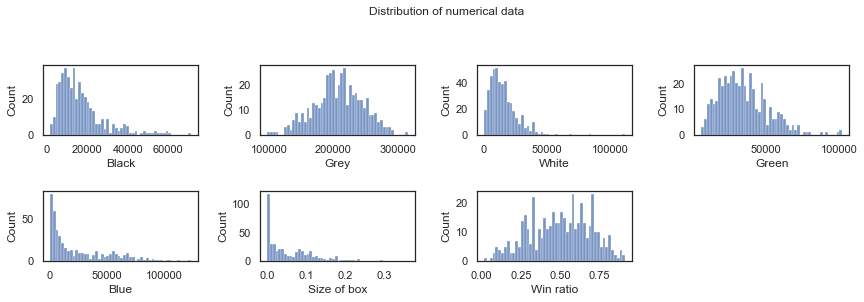

In [125]:
# plots distribution
fig = plt.figure(figsize=(14,10))

for i in range(df_model_final.columns.shape[0]):
    col = df_model_final.iloc[:,i]
    ax = plt.subplot(5, 4 ,i+1)
    sns.histplot(col, stat="count",ax = ax, bins = 50)
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4, hspace=0.8)

fig.suptitle("Distribution of numerical data")

plt.show()

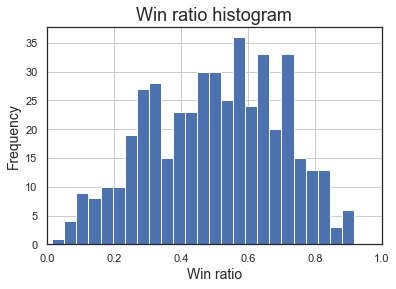

In [126]:
df_model_final['Win ratio'].hist(bins=25)
plt.title('Win ratio histogram',fontsize=18)
plt.xlabel('Win ratio',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xlim([0,1])
plt.savefig('win_ratio.png')
plt.show()

## Projecting in 2D (PCA)

In [127]:
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.decomposition   import PCA

In [128]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['Win ratio'])
features = list(set(list(df_model_final.columns)) - set(['Win ratio']))
X = df_model_final.loc[:, features]
#X

In [129]:
# Standardize the data
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)

pca2 = PCA(n_components=2)
pca2.fit(X_stand)
X_proj = pca2.transform(X_stand)

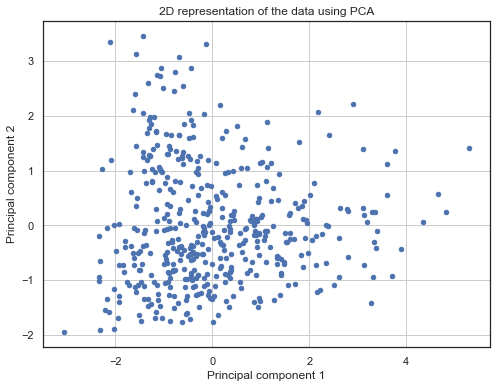

In [130]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))
plt.scatter(X_proj[:,0], X_proj[:, 1], s = 20)
plt.title("2D representation of the data using PCA")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.grid()
plt.show()

In [131]:
pca2.explained_variance_ratio_

array([0.32309233, 0.19430273])

No handles with labels found to put in legend.


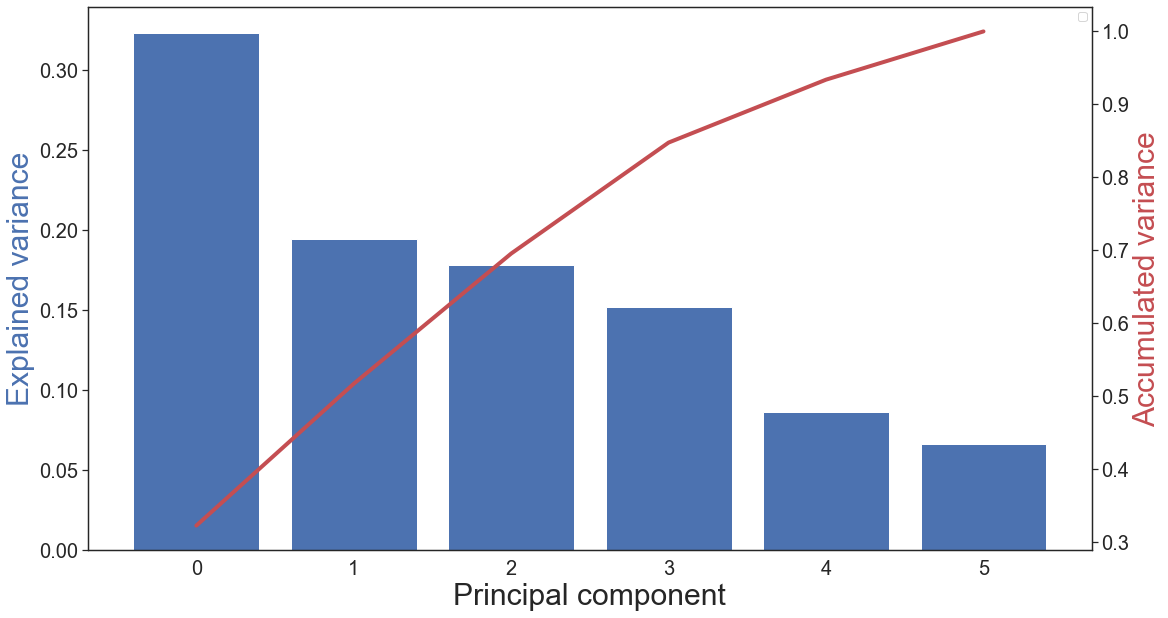

In [132]:
# Look at the number of principal component needed to explain a certain level of variance
_, cols = X_stand.shape

pca = PCA(n_components = cols)
X_new = pca.fit_transform(X_stand)
exp_var = pca.explained_variance_ratio_

x = range(len(exp_var))
sum_exp_var = np.zeros((len(exp_var),1))
prev = 0
for i in x:
    sum_exp_var[i] = prev+exp_var[i]
    prev = sum_exp_var[i]

fig,ax = plt.subplots(figsize = (18,10))

plt.bar(x, exp_var)
ax.set_ylabel("Explained variance",color="b",fontsize=30)
# plt.title('Explained variance of each PC and accumulated variance',fontsize=28)
plt.xlabel('Principal component',fontsize=30)
plt.ylabel('Explained variance')
ax2=ax.twinx()
ax.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.plot(x, sum_exp_var, 'r', linewidth=4)
ax2.set_ylabel("Accumulated variance",color="r",fontsize=30)

# plt.axhline(y=0.95, color = 'red', linestyle = '--', label = "95% explained variance")
plt.legend()
plt.savefig('PC_analysis.png')
plt.show()

One color feature is fully correlated to the others => we can remove Red. We end up with 5 color features, and one object feature.

## Build a Model

In [134]:
# Imports
import os
import math
import random
import itertools

import numpy as np    
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set(style="white")

from math import log

from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import Lasso
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score
from sklearn.metrics         import classification_report

from sklearn.pipeline        import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore') # ignore some warnings

import shap

SEED = 123456789   # Define a random seed so random steps can be replicated. 

In [135]:
# df_model_final = df_model_final[:457]
df_model_final = df_model_final.dropna()

In [136]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['Win ratio'])
features = list(set(list(df_model_final.columns)) - set(['Win ratio']))
X = df_model_final.loc[:, features]

In [137]:
# Divide data into a training set and a testing set using the train_test_split() function
#   NOTE: Please call the subsamples `X_train` ,  `X_test` , `y_train` , `y_test` so we can follow your code
indices = range(0,458,1)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.20, random_state=SEED)

In [138]:
# Define Residual Sum of Squares, and Mean Squared Error to assess regression models
def rss(y, y_hat):
    return sum( [ (yi - yi_hat)**2  for yi, yi_hat in zip(y, y_hat)] )

def mse(y, y_hat, p=0):
    return math.sqrt( (rss(y, y_hat))/ (len(y)-p-1) )

In [140]:
# Define a function to get the features' importance of a tree based model
def print_feature_importance(tree_model, feature_names):
    """
    Function to print a list of features from an sklearn tree model (ranked by importance of the feature)
    
    Args:
        tree_model       A sklearn DecisionTreeClassifier()
        feature_names    A list of features used by the DecisionTreeClassifier
    """
    print('Feature'.center(52), '   ',  'Importance')
    print('=' * 80)
    for index in reversed(np.argsort(tree_model.feature_importances_)):
        print(str(feature_names[index]).center(52) , '   ', '{0:.4f}'.format(tree_model.feature_importances_[index]).center(8))

# Predicting the appeal of images

## Regression models

Try to predict the exact win ratio with regression models.

### Baseline

In [141]:
y_pred = [np.mean(y_train)]*len(y_test)
print("Average appeal is", np.round(np.mean(y_train), decimals = 4))

Average appeal is 0.5024


In [142]:
mse_baseline = mse(y_test, y_pred)
print("Baseline mean square error:", round(mse(y_test, y_pred), 4))

Baseline mean square error: 0.1798


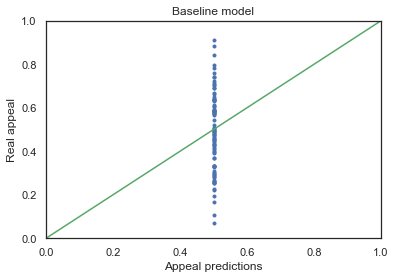

In [143]:
plt.plot(y_pred,y_test, linestyle='', marker='o', markersize=3)
sns.kdeplot(y_pred,y_test, cmap="Reds", shade=True)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Baseline model')
plt.xlabel('Appeal predictions')
plt.ylabel('Real appeal')
plt.show()

### Linear Model with Lasso

In [144]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('ols_model_l1', Lasso()))                 # tell pipeline to use a linear model with lasso
pipeline_lasso = Pipeline(estimators) 

In [145]:
pipeline_lasso.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('ols_model_l1', Lasso())],
 'verbose': False,
 'standardize': StandardScaler(),
 'ols_model_l1': Lasso(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'ols_model_l1__alpha': 1.0,
 'ols_model_l1__copy_X': True,
 'ols_model_l1__fit_intercept': True,
 'ols_model_l1__max_iter': 1000,
 'ols_model_l1__normalize': False,
 'ols_model_l1__positive': False,
 'ols_model_l1__precompute': False,
 'ols_model_l1__random_state': None,
 'ols_model_l1__selection': 'cyclic',
 'ols_model_l1__tol': 0.0001,
 'ols_model_l1__warm_start': False}

In [146]:
###Linear model with LASSO###
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lam_range = np.logspace(-7,3,11)

splits_num = 5

MSE = np.zeros((splits_num, len(lam_range)))

for i in range(len(lam_range)):

    kf = KFold(n_splits=splits_num)

    k = 0
    for learn_index, val_index in kf.split(x_train):
        x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
        y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

        pipeline_lasso.set_params(ols_model_l1__alpha = lam_range[i])
        pipeline_lasso.fit(x_train_train, y_train_train)
        y_pred_lasso_proba = pipeline_lasso.predict(x_train_val)

        MSE[k, i] = round(mse(y_train_val, y_pred_lasso_proba), 4)

        k = k+1

mse_mean = np.zeros(len(lam_range))
mse_std = np.zeros(len(lam_range))
for i in range(len(lam_range)):
    mse_mean[i] = MSE[:, i].mean()
    mse_std[i] = MSE[:, i].std()
    
MSE_df = pd.DataFrame(lam_range.reshape(-1,1), columns = ["lambda"])
MSE_df["MSE-mean"] = mse_mean[:]
MSE_df["MSE-std"] = mse_std[:]
display(MSE_df)

,lambda,MSE-mean,MSE-std
0,1.000000e-07,0.15808,0.014550
1,1.000000e-06,0.15808,0.014550
2,1.000000e-05,0.15808,0.014550
3,1.000000e-04,0.15808,0.014574
4,1.000000e-03,0.15814,0.014575
5,1.000000e-02,0.16024,0.014346
6,1.000000e-01,0.19208,0.011272
7,1.000000e+00,0.20082,0.010001
8,1.000000e+01,0.20082,0.010001
9,1.000000e+02,0.20082,0.010001


In [147]:
# plt.plot(MSE_df['lambda'],MSE_df['MSE-mean'],label='MSE-mean')
# plt.fill_between(MSE_df['lambda'], MSE_df['MSE-mean']-MSE_df['MSE-std'],
#                  MSE_df['MSE-mean']+MSE_df['MSE-std'],'b', alpha=0.4, label='MSE +/- 1 STD')
# plt.xscale('log')
# plt.title('Hyperparameter tuning')
# plt.xlabel('lambda')
# plt.ylabel('Cross-val. MSE')
# plt.legend(loc='upper left')
# plt.show()

In [148]:
lambda_opt = 0.00001# MSE is 0.15334

### SVR

In [149]:
###Support Vector Regression###

estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('svm_model', SVR()))  # tell pipeline to use an SVR model with lasso
pipeline_svr = Pipeline(estimators) 
pipeline_svr.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('svm_model', SVR())],
 'verbose': False,
 'standardize': StandardScaler(),
 'svm_model': SVR(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'svm_model__C': 1.0,
 'svm_model__cache_size': 200,
 'svm_model__coef0': 0.0,
 'svm_model__degree': 3,
 'svm_model__epsilon': 0.1,
 'svm_model__gamma': 'scale',
 'svm_model__kernel': 'rbf',
 'svm_model__max_iter': -1,
 'svm_model__shrinking': True,
 'svm_model__tol': 0.001,
 'svm_model__verbose': False}

In [150]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

c_range = np.logspace(-7,3,11)
mse_mean = np.zeros(len(c_range))

for i in range(len(c_range)):
    pipeline_svr.set_params(svm_model__C = c_range[i])
    pipeline_svr.fit(X_train_train, y_train_train)
    y_pred_svr = pipeline_svr.predict(X_train_val)
    mse_mean[i] = round(mse(y_train_val, y_pred_svr), 4)
                    
mse_df = pd.DataFrame(c_range.reshape(-1,1), columns = ["C"])
mse_df["MSE-mean"] = mse_mean[:]
display(mse_df)

,C,MSE-mean
0,1.000000e-07,0.1927
1,1.000000e-06,0.1927
2,1.000000e-05,0.1926
3,1.000000e-04,0.1921
4,1.000000e-03,0.1880
5,1.000000e-02,0.1661
6,1.000000e-01,0.1461
7,1.000000e+00,0.1536
8,1.000000e+01,0.1852
9,1.000000e+02,0.2074


In [151]:
# plt.plot(mse_df['C'],mse_df['MSE-mean'], label='MSE-mean')
# plt.fill_between(mse_df['C'], mse_df['MSE-mean']-mse_df['MSE-std'],
#                  mse_df['MSE-mean']+mse_df['MSE-std'],'b', alpha=0.4, label='MSE +/- 1 STD')
# plt.xscale('log')
# plt.title('Hyperparameter tuning')
# plt.xlabel('c')
# plt.ylabel('MSE')
# plt.legend(loc='upper left')
# plt.show()

In [152]:
c_opt = 0.1 # MSE is 0.1396

### Comparing models
Both regularised models reach very similar performances in terms of mean square error. However, the SVR performs slightly better. This better performance is still present on the test set.

### Test score

#### Linear Regression model

In [153]:
pipeline_lasso.set_params(ols_model_l1__alpha = lambda_opt)
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)
print("Testing MSE (LASSO):", round(mse(y_test, y_pred_lasso), 4))
print("Decrease in error with respect to baseline:", np.round((mse_baseline-mse(y_test, y_pred_lasso))/mse_baseline*100, decimals = 2), "%")

Testing MSE (LASSO): 0.1421
Decrease in error with respect to baseline: 20.97 %


In [154]:
linreglasso_results = {'Predicted_val': y_pred_lasso, 'Real_val': y_test}
linreglasso_results = pd.DataFrame(linreglasso_results)
#linreglasso_results

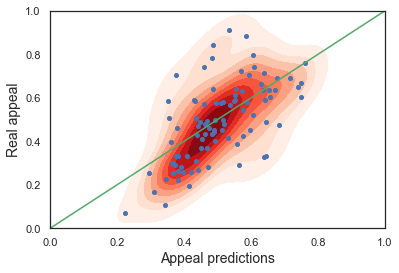

In [155]:
plt.plot(y_pred_lasso,y_test, linestyle='', marker='o', markersize=4)
sns.kdeplot(y_pred_lasso,y_test, cmap="Reds", shade=True)
# m, b = np.polyfit(y_pred_lasso, y_test, 1)
# plt.plot(y_pred_lasso, m*y_pred_lasso + b)
plt.plot([0,1],[0,1], 'g')
plt.xlim([0,1])
plt.ylim([0,1])
# plt.title('Linear regression model using lasso regularization',fontsize=16)
plt.xlabel('Appeal predictions',fontsize=14)
plt.ylabel('Real appeal',fontsize=14)
plt.savefig('LinReg_model.png')
plt.show()

------------------------
#### SVR model

In [156]:
pipeline_svr.set_params(svm_model__C = c_opt)
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_test)
print("Testing MSE (SVR):", round(mse(y_test, y_pred_svr), 4))
print("Decrease in error with respect to baseline:", np.round((mse_baseline-mse(y_test, y_pred_svr))/mse_baseline*100, decimals = 2), "%")

svr = pipeline_svr.named_steps['svm_model']

Testing MSE (SVR): 0.1345
Decrease in error with respect to baseline: 25.16 %


In [157]:
svr_results = {'Predicted_val': y_pred_svr, 'Real_val': y_test}
svr_results = pd.DataFrame(svr_results)
# svr_results

In [158]:
# indices_test

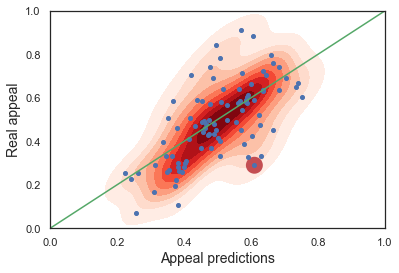

In [159]:
plt.plot(y_pred_svr,y_test, linestyle='', marker='o', markersize=4)
sns.kdeplot(y_pred_svr,y_test, cmap="Reds", shade=True)
plt.scatter(0.6102,0.29, linewidth=8, s=80, facecolors='none', edgecolors='r')
# m2, b2 = np.polyfit(y_pred_svr, y_test, 1)
# plt.plot(y_pred_svr, m2*y_pred_svr + b2)
plt.plot([0,1],[0,1], 'g')
plt.xlim([0,1])
plt.ylim([0,1])
# plt.title('Support Vector Regression model',fontsize=16)
plt.xlabel('Appeal predictions',fontsize=14)
plt.ylabel('Real appeal',fontsize=14)
plt.savefig('SVR_model.png')
plt.show()

Although more data is an easy answer to how we can improve the performance of the regressors, there are other ways to do so. One could explore feature engineering and dimensionality reduction (e.g. PCA) or feature selection through more varied types of regularisation. Another possibility would be to transform the regression problem into a multi-class classification problem where big deviations from the true value can be appropriately penalised.

## Classification models

Try to predict the belonging class of an image by dividing the win ratio into discrete classes.

### Dataset classes

In [51]:
# Efine the number of classes for the classification model
df_model_final['class'] = 0
nclasses = 5

In [52]:
# Transform into classes 1 to nclasses
step = 1/nclasses
print(step)
for i in range(nclasses):
    inf = float("{:.4f}".format(i*step))
    sup = float("{:.4f}".format((i+1)*step))
    print(inf,sup)
    if (sup < 1):
        df_model_final['class'][(df_model_final['Win ratio'] >= inf) & (df_model_final['Win ratio'] < sup)] = i+1
    else :
        df_model_final['class'][(df_model_final['Win ratio'] >= inf)] = i+1    


0.2
0.0 0.2
0.2 0.4
0.4 0.6
0.6 0.8
0.8 1.0


In [53]:
df_model_final = df_model_final.drop('Win ratio', axis=1)

In [54]:
df_model_final['class'].value_counts()

3    160
4    131
2    109
1     32
5     26
Name: class, dtype: int64

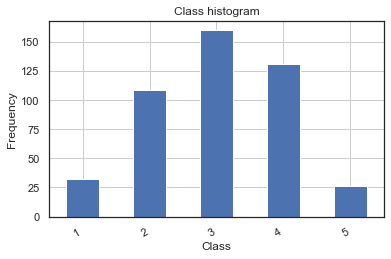

In [55]:
# Plot the distribution of classes
stars = pd.Series((1, 2, 3, 4, 5, 6))
vc = df_model_final['class'].value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()
plt.title('Class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid()
plt.savefig('hist_class.png')
plt.show()

In [56]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['class'])
features = list(set(list(df_model_final.columns)) - set(['class']))
X = df_model_final.loc[:, features]

In [57]:
# Divide data into a training set and a testing set using the train_test_split() function
#   NOTE: Please call the subsamples `X_train` ,  `X_test` , `y_train` , `y_test` so we can follow your code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

### Baseline

In [58]:
from numpy import argmax
from tensorflow.keras.utils import to_categorical

In [59]:
# Predict the most occured outcome

In [60]:
def baseline_model(y_train, y_test):   
    y_train_df = pd.DataFrame(y_train)
    most_freq = np.argmax(y_train_df.value_counts())

    y_hat = np.array([int(np.round(y_train_df.value_counts().index[most_freq]))]*len(y_train))
    y_hat_df = pd.DataFrame((y_hat), columns = ["prediction"])
    y_hat_df["truth"] = y_train
    #y_hat_df.head()

    y_hat = [int(np.round(y_train_df.value_counts().index[most_freq]))]*len(y_test)
    cm = confusion_matrix(y_test, y_hat)
    print(y_test)
    acc =np.diagonal(cm).sum()/cm.sum()
    
    encoded_test = to_categorical(y_test, num_classes=nclasses + 1)
    encoded_hat = to_categorical(y_hat, num_classes=nclasses + 1)
    
    auc = roc_auc_score(encoded_test[:,1:], encoded_hat[:,1:], multi_class="ovr", average='macro')
    
    return y_hat_df, acc, auc

In [61]:
y_hat_df, acc_baseline, auc_baseline = baseline_model(y_train, y_test)
y_hat_df.head()

[2 3 4 4 2 3 2 3 4 4 3 3 3 2 4 3 2 3 2 3 3 2 2 2 3 1 4 2 4 4 3 4 2 3 3 2 4
 3 2 1 3 1 2 2 4 5 3 4 2 3 3 2 3 2 4 2 4 3 3 2 3 3 3 4 3 3 4 2 4 4 3 3 4 4
 3 4 3 3 2 2 3 4 2 3 3 3 1 4 5 3 5 3]


,prediction,truth
0,3,4
1,3,2
2,3,4
3,3,1
4,3,4


In [62]:
auc_baseline

0.5

### Linear OLS model

The first model we will try is a linear regression coupled with LASSO regularisation. We will determine the optimal  𝜆  (LASSO hypereparameter) which maximises the AUC score of the model. In our first approach, we will not apply any kind of PCA.

In [63]:
def ols_lasso_CV(x_train, y_train, lam_range):
    splits_num = 5

    AUC = np.zeros((splits_num, len(lam_range)))

    for i in range(len(lam_range)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_lasso.set_params(ols_model_l1__alpha = lam_range[i])
            pipeline_lasso.fit(x_train_train, y_train_train)
            y_pred_lasso_proba = pipeline_lasso.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)

            '''ERROR HERE'''
            max_y_pred = (nclasses + 1)/10 - 0.1
            y_pred_lasso_proba = np.clip(y_pred_lasso_proba,0,max_y_pred) #doing this fix it, not sure that's good
            encoded_y_pred_lasso_proba = to_categorical(y_pred_lasso_proba, num_classes=nclasses + 1)
            '''ERROR HERE'''

            
            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_lasso_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(lam_range))
    auc_std = np.zeros(len(lam_range))
    for i in range(len(lam_range)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [64]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('ols_model_l1', Lasso()))                 # tell pipeline to use a linear model with lasso
pipeline_lasso = Pipeline(estimators) 

In [65]:
pipeline_lasso.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('ols_model_l1', Lasso())],
 'verbose': False,
 'standardize': StandardScaler(),
 'ols_model_l1': Lasso(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'ols_model_l1__alpha': 1.0,
 'ols_model_l1__copy_X': True,
 'ols_model_l1__fit_intercept': True,
 'ols_model_l1__max_iter': 1000,
 'ols_model_l1__normalize': False,
 'ols_model_l1__positive': False,
 'ols_model_l1__precompute': False,
 'ols_model_l1__random_state': None,
 'ols_model_l1__selection': 'cyclic',
 'ols_model_l1__tol': 0.0001,
 'ols_model_l1__warm_start': False}

In [66]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lam_range = np.logspace(-7,3,11)

auc_mean, auc_std = ols_lasso_CV(x_train, y_train, lam_range)

In [67]:
auc_df = pd.DataFrame(lam_range.reshape(-1,1), columns = ["Lambda"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,Lambda,AUC-mean,AUC-std
0,1.000000e-07,0.5,0.0
1,1.000000e-06,0.5,0.0
2,1.000000e-05,0.5,0.0
3,1.000000e-04,0.5,0.0
4,1.000000e-03,0.5,0.0
5,1.000000e-02,0.5,0.0
6,1.000000e-01,0.5,0.0
7,1.000000e+00,0.5,0.0
8,1.000000e+01,0.5,0.0
9,1.000000e+02,0.5,0.0


In [68]:
# lambda_ols_class = 0.0001
# auc_linear = 0.63132

### Logit model

We now try a logit model with LASSO regularisation and optimise for the C parameter of the regularisation. We approach the problem in the same way as for the previous model.

In [69]:
def logit_CV(x_train, y_train, c_range):
    splits_num = 5

    AUC = np.zeros((splits_num, len(c_range)))

    for i in range(len(c_range)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_logit.set_params(logit_model_l1__C = c_range[i])

            pipeline_logit.fit(x_train_train, y_train_train)

            y_pred_logit_proba = pipeline_logit.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_logit_proba = to_categorical(y_pred_logit_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_logit_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(c_range))
    auc_std = np.zeros(len(c_range))
    for i in range(len(c_range)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [70]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('logit_model_l1', LogisticRegression(penalty = "l1", solver = "saga", random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_logit = Pipeline(estimators) 
pipeline_logit.get_params()

logit_model = pipeline_logit.named_steps['logit_model_l1']

In [71]:
c_range = np.logspace(-3,6,11)

auc_mean, auc_std = logit_CV(x_train, y_train, c_range)
    
auc_df = pd.DataFrame(c_range.reshape(-1,1), columns = ["C"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,C,AUC-mean,AUC-std
0,0.001000,0.54400,0.018344
1,0.007943,0.58338,0.032528
2,0.063096,0.62104,0.053615
3,0.501187,0.61930,0.040578
4,3.981072,0.62276,0.044920
5,31.622777,0.62276,0.041554
6,251.188643,0.62276,0.041554
7,1995.262315,0.62276,0.041554
8,15848.931925,0.62276,0.041554
9,125892.541179,0.62276,0.041554


In [72]:
# c_logit_class = 1
# auc_logit = 0.64482

### SVM model

In [73]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('svm_model', SVC(probability = True, random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_svc = Pipeline(estimators) 
pipeline_svc.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('svm_model', SVC(probability=True, random_state=123456789))],
 'verbose': False,
 'standardize': StandardScaler(),
 'svm_model': SVC(probability=True, random_state=123456789),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'svm_model__C': 1.0,
 'svm_model__break_ties': False,
 'svm_model__cache_size': 200,
 'svm_model__class_weight': None,
 'svm_model__coef0': 0.0,
 'svm_model__decision_function_shape': 'ovr',
 'svm_model__degree': 3,
 'svm_model__gamma': 'scale',
 'svm_model__kernel': 'rbf',
 'svm_model__max_iter': -1,
 'svm_model__probability': True,
 'svm_model__random_state': 123456789,
 'svm_model__shrinking': True,
 'svm_model__tol': 0.001,
 'svm_model__verbose': False}

For the SVM classifier, 5-fold cross-validation is included in the sklearn command.

In [74]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=SEED)

In [75]:
c_range = np.logspace(-3,6,11)
auc_mean = np.zeros(len(c_range))

for i in range(len(c_range)):
    pipeline_svc.set_params(svm_model__C = c_range[i])
    pipeline_svc.fit(X_train_train, y_train_train)
    y_pred_svc_proba = pipeline_svc.predict(X_train_val)
    encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
    encoded_y_pred_svm_proba = to_categorical(y_pred_svc_proba, num_classes=nclasses + 1)
    auc_mean[i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_svm_proba[:,1:], 
                                      multi_class="ovr", average='micro'), 4)
                    
auc_df = pd.DataFrame(c_range.reshape(-1,1), columns = ["C"])
auc_df["AUC"] = auc_mean[:]
display(auc_df)

,C,AUC
0,0.001000,0.5856
1,0.007943,0.5856
2,0.063096,0.5856
3,0.501187,0.6399
4,3.981072,0.6467
5,31.622777,0.6196
6,251.188643,0.5720
7,1995.262315,0.5720
8,15848.931925,0.5788
9,125892.541179,0.5788


In [76]:
# c_svm_class = 10
# auc_svm = 0.6128

### KNN
Similarly as before, let's build a pipeline for a KNN model.

In [77]:
def knn_CV(x_train, y_train, n_neighb):
    splits_num = 5

    AUC = np.zeros((splits_num, len(n_neighb)))

    for i in range(len(n_neighb)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_knn.set_params(knn_model__n_neighbors = n_neighb[i])

            pipeline_knn.fit(x_train_train, y_train_train)

            y_pred_knn_proba = pipeline_knn.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_knn_proba = to_categorical(y_pred_knn_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_knn_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(n_neighb))
    auc_std = np.zeros(len(n_neighb))
    for i in range(len(n_neighb)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [78]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('knn_model',KNeighborsClassifier()))  # tell pipeline to use a logit model with lasso
pipeline_knn = Pipeline(estimators) 
pipeline_knn.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('knn_model', KNeighborsClassifier())],
 'verbose': False,
 'standardize': StandardScaler(),
 'knn_model': KNeighborsClassifier(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'knn_model__algorithm': 'auto',
 'knn_model__leaf_size': 30,
 'knn_model__metric': 'minkowski',
 'knn_model__metric_params': None,
 'knn_model__n_jobs': None,
 'knn_model__n_neighbors': 5,
 'knn_model__p': 2,
 'knn_model__weights': 'uniform'}

In [79]:
n_neighb = np.arange(2, 15, 1)

auc_mean, auc_std = knn_CV(x_train, y_train, n_neighb)
    
auc_df = pd.DataFrame(n_neighb.reshape(-1,1), columns = ["N"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,N,AUC-mean,AUC-std
0,2,0.61084,0.032260
1,3,0.58338,0.015371
2,4,0.59872,0.032743
3,5,0.60564,0.038301
4,6,0.62612,0.022224
5,7,0.63976,0.026075
6,8,0.64832,0.028428
7,9,0.63460,0.026650
8,10,0.63288,0.033779
9,11,0.64144,0.034829


In [80]:
# n_knn_class = 5
# auc_knn = 0.60548

### Decision trees

In [81]:
def dtc_CV(x_train, y_train, d_depth):
    splits_num = 5

    AUC = np.zeros((splits_num, len(d_depth)))

    for i in range(len(d_depth)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_dtc.set_params(dtc_model__max_depth = d_depth[i])

            pipeline_dtc.fit(x_train_train, y_train_train)

            y_pred_dtc_proba = pipeline_dtc.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_dtc_proba = to_categorical(y_pred_dtc_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_dtc_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(d_depth))
    auc_std = np.zeros(len(d_depth))
    for i in range(len(d_depth)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [82]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('dtc_model',DecisionTreeClassifier(random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_dtc = Pipeline(estimators) 
pipeline_dtc.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('dtc_model', DecisionTreeClassifier(random_state=123456789))],
 'verbose': False,
 'standardize': StandardScaler(),
 'dtc_model': DecisionTreeClassifier(random_state=123456789),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'dtc_model__ccp_alpha': 0.0,
 'dtc_model__class_weight': None,
 'dtc_model__criterion': 'gini',
 'dtc_model__max_depth': None,
 'dtc_model__max_features': None,
 'dtc_model__max_leaf_nodes': None,
 'dtc_model__min_impurity_decrease': 0.0,
 'dtc_model__min_impurity_split': None,
 'dtc_model__min_samples_leaf': 1,
 'dtc_model__min_samples_split': 2,
 'dtc_model__min_weight_fraction_leaf': 0.0,
 'dtc_model__presort': 'deprecated',
 'dtc_model__random_state': 123456789,
 'dtc_model__splitter': 'best'}

In [83]:
d_depth = np.arange(2, 15, 1)

auc_mean, auc_std = dtc_CV(x_train, y_train, d_depth)
    
auc_df = pd.DataFrame(d_depth.reshape(-1,1), columns = ["D"])
auc_df["AUC-mean"] = auc_mean[:]
auc_df["AUC-std"] = auc_std[:]
display(auc_df)

,D,AUC-mean,AUC-std
0,2,0.64496,0.037752
1,3,0.61926,0.029927
2,4,0.61928,0.032432
3,5,0.61242,0.026194
4,6,0.60562,0.040151
5,7,0.60560,0.046254
6,8,0.58686,0.035387
7,9,0.57482,0.039445
8,10,0.56628,0.032499
9,11,0.57140,0.042743


In [84]:
# d_dtc_class = 2
# auc_dtc = 0.61058

### Random Forest

In [85]:
def randfor_CV(x_train, y_train, f_depth):
    splits_num = 5

    AUC = np.zeros((splits_num, len(f_depth)))

    for i in range(len(f_depth)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_randfor.set_params(randfor_model__max_depth = f_depth[i])

            pipeline_randfor.fit(x_train_train, y_train_train)

            y_pred_randfor_proba = pipeline_randfor.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_randfor_proba = to_categorical(y_pred_randfor_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_randfor_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(f_depth))
    auc_std = np.zeros(len(f_depth))
    for i in range(len(f_depth)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [86]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('randfor_model',RandomForestClassifier(random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_randfor = Pipeline(estimators)

random_forest = pipeline_randfor.named_steps['randfor_model']

pipeline_randfor.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('randfor_model', RandomForestClassifier(random_state=123456789))],
 'verbose': False,
 'standardize': StandardScaler(),
 'randfor_model': RandomForestClassifier(random_state=123456789),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'randfor_model__bootstrap': True,
 'randfor_model__ccp_alpha': 0.0,
 'randfor_model__class_weight': None,
 'randfor_model__criterion': 'gini',
 'randfor_model__max_depth': None,
 'randfor_model__max_features': 'auto',
 'randfor_model__max_leaf_nodes': None,
 'randfor_model__max_samples': None,
 'randfor_model__min_impurity_decrease': 0.0,
 'randfor_model__min_impurity_split': None,
 'randfor_model__min_samples_leaf': 1,
 'randfor_model__min_samples_split': 2,
 'randfor_model__min_weight_fraction_leaf': 0.0,
 'randfor_model__n_estimators': 100,
 'randfor_model__n_jobs': None,
 'randfor_model__oob_score': False,
 'randfor_model__random_state': 1234

In [87]:
# f_depth = np.arange(2, 15, 1)

# auc_mean, auc_std = randfor_CV(x_train, y_train, f_depth)
    
# auc_df = pd.DataFrame(f_depth.reshape(-1,1), columns = ["F"])
# auc_df["AUC-mean"] = auc_mean[:]
# auc_df["AUC-std"] = auc_std[:]
# display(auc_df)

In [88]:
# f_randfor_class = 3
# auc_randfor = 0.61058

### Test AUC

We finally test our models on unforeseen data and compute the AUC. The logit model performs better and obtains a higher AUC score. If we wanted to compare the models even more thoroughly we could have performed a form of nested cross-validation where inner folds are used to optimise hyperparameters while outer folds allow to select the best model.

In [89]:
print("Test AUC (baseline):", auc_baseline)

lambda_ols_class=0.02
pipeline_lasso.set_params(ols_model_l1__alpha = lambda_ols_class)
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso_proba = pipeline_lasso.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_lasso_proba = to_categorical(y_pred_lasso_proba, num_classes=nclasses + 1)
print("Test AUC (LASSO):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_lasso_proba[:,1:],
                                         multi_class="ovr", average='micro'))


c_logit_class=0.12
pipeline_logit.set_params(logit_model_l1__C = c_logit_class)
pipeline_logit.fit(X_train, y_train)
y_pred_logit_proba = pipeline_logit.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_logit_proba = to_categorical(y_pred_logit_proba, num_classes=nclasses + 1)
print("Test AUC (logit):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_logit_proba[:,1:],
                                         multi_class="ovr", average='micro'))  

c_svm_class=0.9                      
pipeline_svc.set_params(svm_model__C = c_svm_class)
pipeline_svc.fit(X_train, y_train)
y_pred_svc_proba = pipeline_svc.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_svc_proba = to_categorical(y_pred_svc_proba, num_classes=nclasses + 1)
print("Test AUC (SVM):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_svc_proba[:,1:],
                                         multi_class="ovr", average='micro'))

n_knn_class=57
pipeline_knn.set_params(knn_model__n_neighbors = n_knn_class)
pipeline_knn.fit(X_train, y_train)
y_pred_knn_proba = pipeline_knn.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_knn_proba = to_categorical(y_pred_knn_proba, num_classes=nclasses + 1)
print("Test AUC (KNN):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_knn_proba[:,1:],
                                         multi_class="ovr", average='micro'))

d_depth=2
pipeline_dtc.set_params(dtc_model__max_depth = d_depth)
pipeline_dtc.fit(X_train, y_train)
y_pred_dtc_proba = pipeline_dtc.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_dtc_proba = to_categorical(y_pred_dtc_proba, num_classes=nclasses + 1)
print("Test AUC (Dec. Tree):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_dtc_proba[:,1:],
                                         multi_class="ovr", average='micro'))

f_randfor_class=2
pipeline_randfor.set_params(randfor_model__max_depth = f_randfor_class)
pipeline_randfor.fit(X_train, y_train)
y_pred_randfor_proba = pipeline_randfor.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_randfor_proba = to_categorical(y_pred_randfor_proba, num_classes=nclasses + 1)
print("Test AUC (Rand. For.):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_randfor_proba[:,1:],
                                         multi_class="ovr", average='micro'))

   
                                    

Test AUC (baseline): 0.5
Test AUC (LASSO): 0.6739130434782608
Test AUC (logit): 0.7758152173913043
Test AUC (SVM): 0.735054347826087
Test AUC (KNN): 0.735054347826087
Test AUC (Dec. Tree): 0.7146739130434783
Test AUC (Rand. For.): 0.7146739130434783


In [90]:
models_classification = pd.DataFrame([[auc_baseline], [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_lasso_proba[:,1:], multi_class="ovr", average='micro')],
                                    [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_logit_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_svc_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_knn_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_dtc_proba[:,1:], multi_class="ovr", average='micro')],
                                     [roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_randfor_proba[:,1:], multi_class="ovr", average='micro')]],
                                    index=['baseline','Lasso','logit','SVM','KNN','Dec. Tree','Rand. For.'], columns=['Test AUC'])

In [91]:
models_classification

,Test AUC
baseline,0.500000
Lasso,0.673913
logit,0.775815
SVM,0.735054
KNN,0.735054
Dec. Tree,0.714674
Rand. For.,0.714674


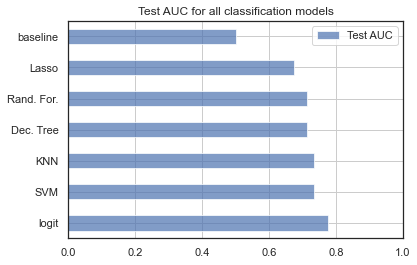

In [92]:
models_classification.sort_values(by='Test AUC', ascending=False).plot(kind='barh', alpha=0.7)
plt.title('Test AUC for all classification models')
plt.xlim(0,1)
plt.grid();

### Confusion matrix for the best classifier

In [93]:
cm_opt = confusion_matrix(y_test,y_pred_logit_proba)
cm_opt

array([[ 0,  3,  1,  0,  0],
       [ 0, 15,  6,  3,  0],
       [ 0,  4, 27,  7,  0],
       [ 0,  0,  6, 17,  0],
       [ 0,  0,  2,  1,  0]], dtype=int64)

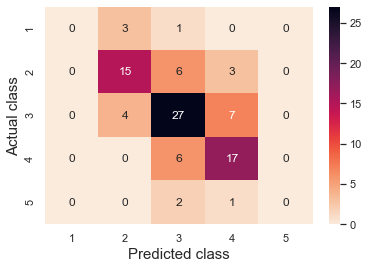

In [94]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(cm_opt, annot=True, cmap = cmap)
yticks = [1,2,3,4,5]
ax.set_yticklabels(yticks)
ax.set_xticklabels(yticks)
# plt.title('Confusion matrix for the logit model',fontsize=18)
plt.xlabel('Predicted class',fontsize=15)
plt.ylabel('Actual class',fontsize=15)
plt.savefig('CM_bestmodel.png')
plt.show()

In [95]:
diff_target = np.abs(y_pred_logit_proba-y_test)
print('Proportion of images correctly classified', round(np.count_nonzero(diff_target == 0)/np.sum(cm_opt),4))
print('Proportion of images classified at 1 class away from the truth',
      round(np.count_nonzero(diff_target == 1)/np.sum(cm_opt),4))
print('Proportion of images classified at 2 classes away from the truth',
      round(np.count_nonzero(diff_target == 2)/np.sum(cm_opt),4))
print('Proportion of images classified at 3 classes away from the truth',
      round(np.count_nonzero(diff_target == 3)/np.sum(cm_opt),4))

Proportion of images correctly classified 0.6413
Proportion of images classified at 1 class away from the truth 0.2935
Proportion of images classified at 2 classes away from the truth 0.0652
Proportion of images classified at 3 classes away from the truth 0.0


### Feature importance

Logit does not provide any kind of "feature importance" function, so we use the second best model to try to understand which features explain the most the outcome, which is the random forest.

In [96]:
print_feature_importance(random_forest, X_train.columns)

                      Feature                            Importance
                       Green                              0.4482 
                        Grey                              0.1690 
                       White                              0.1370 
                       Black                              0.1267 
                        Blue                              0.0630 
                    Size of box                           0.0562 
